In [1]:
%matplotlib nbagg
import functools
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import scipy.integrate as spi
import scipy.optimize as spo
import scipy.interpolate as spolate

In [26]:
def hybrid_sim(flow_map, jump_map, jump_event, x0, t_range, max_jumps, other_events=()):
    """
    Given a hybrid system in the form of the following components:
        flow_map(t, x) -> dx/dt
        jump_map(t, x) -> x+
        jump_event(t, x) -> continuous, positive inside the
                            jump set, negative outside

    Computes a solution from the initial condition x0 over the
    evaluation range t_range = (t_start, t_stop) or up to the 
    maximum number of jumps max_jumps, whichever comes first.

    Can also take other_events, an optional list of events to
    track; the times at which these events occur DURING FLOW
    are recorded and returned. 

    Returns
        tout : the evaluation times in a hybrid time domain
        Xout : the state trajectory corresponding to those times
        tev : the times at which each custom event occurred
    """
    jump_event.terminal = True
    jump_event.direction = 1
    events = (jump_event,) + other_events

    xouts = []
    touts = []
    tev = [[] for _ in events]

    i = 0
    jumps = 0
    while jumps < max_jumps:
        # Compute and save the results until an event or the end.
        res = spi.solve_ivp(flow_map, t_range, x0, events=events)

        # Save the latest portion of the state trajectory.
        xouts.append(res.y)

        # Save the evaluation times in a hybrid time domain.
        thist = np.vstack((res.t, np.ones_like(res.t) * jumps))
        touts.append(thist)

        # Save all the event times.
        for i, arr in enumerate(res.t_events):
            tev[i] += list(arr)

        # Done because of failure or reaching t_stop.
        if res.status==0 or res.status==-1: break

        # Not done, so jump. Awkward syntax because if multiple jumps
        # occur in sequence, one will be automatically entered into 
        x0 = jump_map(res.t[-1], res.y[:,-1])
        jumps += 1
        
        while jump_event(res.t[-1], x0) >= 0:
            x0 = jump_map(res.t[-1], x0)
            jumps += 1
        t_range = res.t[-1], t_range[1]

    touts = np.hstack(touts)
    xouts = np.hstack(xouts)
    return touts, xouts.T, tev


In [95]:
# Model for cortical RS pyramidal neuron taken from Izhikevich (2007)
# Add a component for extracellular voltage!
Cext, Gext = 1000, 10  # :: pF, nS
C, k = 100, 0.7 # :: pF, pA/mV^2
vr, vt, vp = -60, -40, 35 # :: mV
a, b, c, d = 0.03, -2, -50, 100 # :: pA/s, nS, mV, pA

# Saddle node bifurcation point.
Istar = k/4 * (vr - vt - b/k)**2

def jump_map(t, vue):
    return np.array([c,d, C/Cext*(vp-c)]) + np.array([0,1,1]) * vue

def flow_map(I, t, vue):
    v, u, e = vue
    Ina = k * (v - vr) * (v - vt)
    vdot = (Ina - u + I)/C
    udot = a * (b * (v - vr) - u)
    edot = (u - Ina - I)/Cext
    return np.array([vdot, udot, edot])

def P(t, vu):
    return vu[0] - vp


In [96]:
# Run one simulation.
Itest = 60#pA
x0 = np.array([(vr + vt)/2, 0, 0])
the_flow = functools.partial(flow_map, Itest)
tout, xout, tev = hybrid_sim(the_flow, jump_map, P, 
                             x0, (0,1000), 100)

<IPython.core.display.Javascript object>


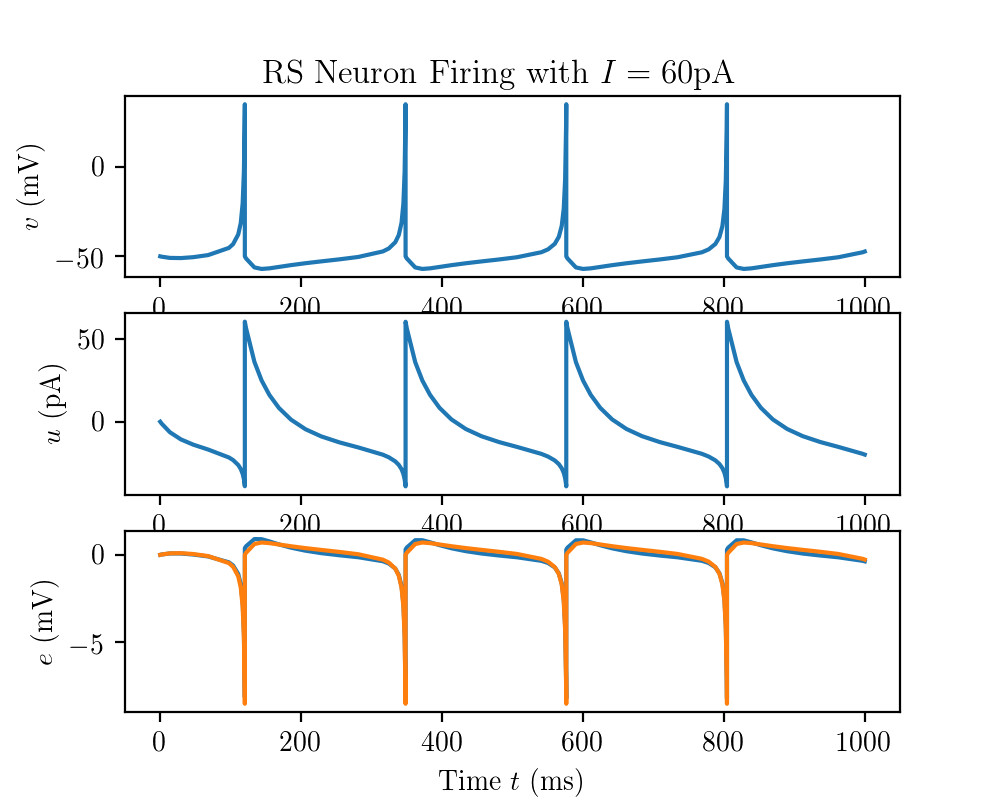

Text(0.5, 0.925, 'RS Neuron Firing with $I = 60\\mathrm{pA}$')

In [99]:
# Plot the phase variables directly just to be sure everything is sane.
plt.figure(figsize=(5,4))

plt.subplot(311)
plt.plot(tout[0,:], xout[:,0])
plt.ylabel('$v$ (mV)')
plt.subplot(312)
plt.plot(tout[0,:], xout[:,1])
plt.ylabel('$u$ (pA)')
plt.subplot(313)
plt.plot(tout[0,:], xout[:,2])
plt.plot(tout[0,:], ((vt+vr)/2 - xout[:,0]) * C/Cext)
plt.ylabel('$e$ (mV)')

plt.xlabel('Time $t$ (ms)')
plt.suptitle('RS Neuron Firing with $I = {}\\mathrm{{pA}}$'.format(Itest), y=0.925)